# Задание

http://www.jeroenclaes.be/statistics_for_linguistics/class7.html

Предсказание среднего времени реакции в лингвистическом эксперименте (целевая переменная - RTlexdec).

Цель - создать наилучшую предсказательную модель с помощью алгоритма линейной регрессии.

### Что необходимо сделать:

1) Исследуйте зависимость целевой переменной от исходных факторов и пар факторов, постройте диаграммы, отражающие эти зависимости.

2) Закодируйте категориальные признаки. Начните с OneHotEncoding, затем попробуйте счетчики.

3) Сделайте масштабирование данных.

4) Обучите линейную регрессию, посмотрите на качество (r2_score) на кросс-валидации.

5) Выведите на экран веса признаков, дайте интерпретацию этим весам.

6) Поработайте над созданием новых признаков (функции от исходных признаков, функции от пар признаков и т.д.). Добейтесь увеличения качества исходного алгоритма.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score


%matplotlib inline
sns.set()

In [6]:
df = pd.read_csv("class7_Baayen_et_al_2006.csv")
df.tail()

,RTlexdec,Familiarity,AgeSubject,WrittenFrequency,WordCategory,LengthInLetters,FrequencyInitialDiphoneWord
4563,6.753998,2.40,old,2.079442,V,3,8.311644
4564,6.711022,3.17,old,3.663562,V,4,12.567203
4565,6.592332,3.87,old,5.043425,V,4,8.920923
4566,6.565561,4.97,old,3.135494,V,5,10.425639
4567,6.667300,3.03,old,4.276666,V,4,9.054388


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568 entries, 0 to 4567
Data columns (total 7 columns):
RTlexdec                       4568 non-null float64
Familiarity                    4568 non-null float64
AgeSubject                     4568 non-null object
WrittenFrequency               4568 non-null float64
WordCategory                   4568 non-null object
LengthInLetters                4568 non-null int64
FrequencyInitialDiphoneWord    4568 non-null float64
dtypes: float64(4), int64(1), object(2)
memory usage: 249.9+ KB


In [8]:
df.shape

(4568, 7)

1) Исследуйте зависимость целевой переменной от исходных факторов и пар факторов, постройте диаграммы, отражающие эти зависимости.

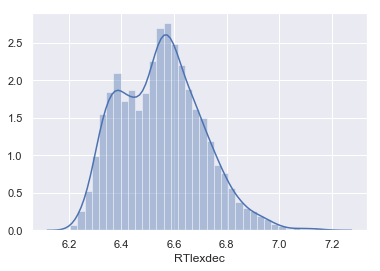

In [9]:
sns.distplot(df['RTlexdec'])  # Распределение целевой переменной

## Посмотрим распределение целевой переменной в разрезе категориальной

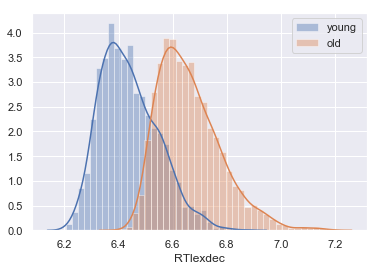

In [10]:
for unique in df.AgeSubject.unique():
    sns.distplot(df[df.AgeSubject == unique]['RTlexdec'], label = unique)
    plt.legend()

У молодых время реакции меньше,чем у пожилых

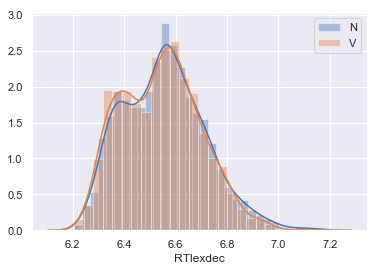

In [11]:
for unique in df.WordCategory.unique():
    sns.distplot(df[df.WordCategory == unique]['RTlexdec'], label = unique)
    plt.legend()

Особой зависимости пока не прослеживается

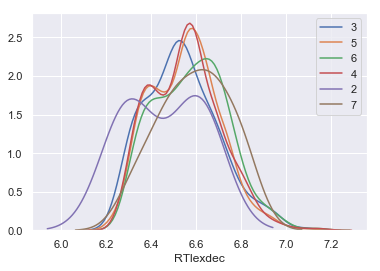

In [12]:
for unique in df.LengthInLetters.unique():
    sns.distplot(df[df.LengthInLetters == unique]['RTlexdec'], label = unique, hist = False)
    plt.legend()

Непонятно, попробуем иначе

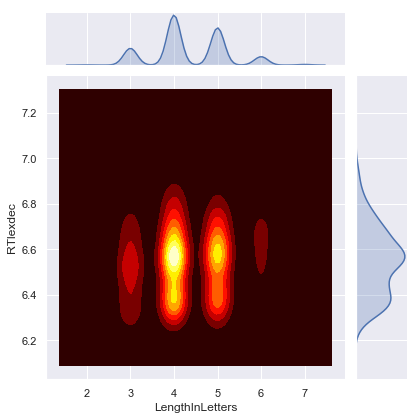

In [13]:
sns.jointplot(df['LengthInLetters'], df['RTlexdec'], kind = 'kde',cmap ='hot');

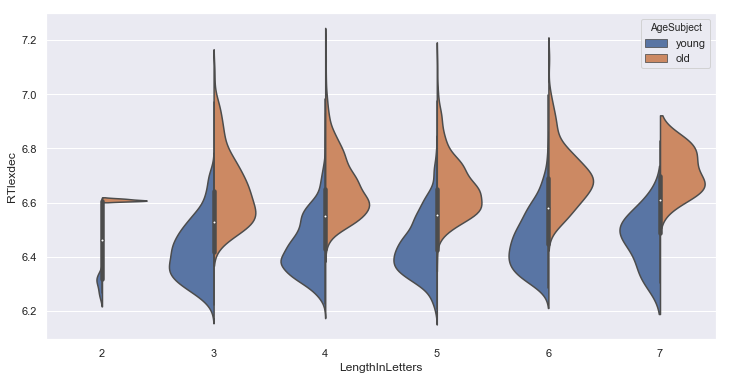

In [14]:
sns.violinplot(y = df['RTlexdec'], x = df['LengthInLetters'], hue = df['AgeSubject'], split=True)
fig = plt.gcf()
fig.set_size_inches(12,6)

Данные хорошо разделяются по возрасту, это уже знаем

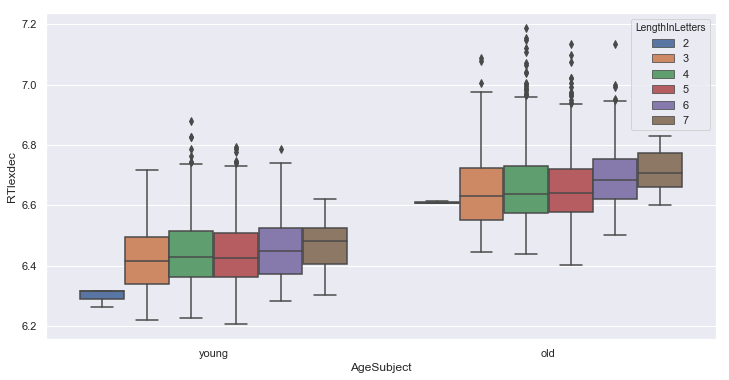

In [15]:
sns.boxplot(y = df['RTlexdec'], x = df['AgeSubject'], hue = df['LengthInLetters'])
fig = plt.gcf()
fig.set_size_inches(12,6)

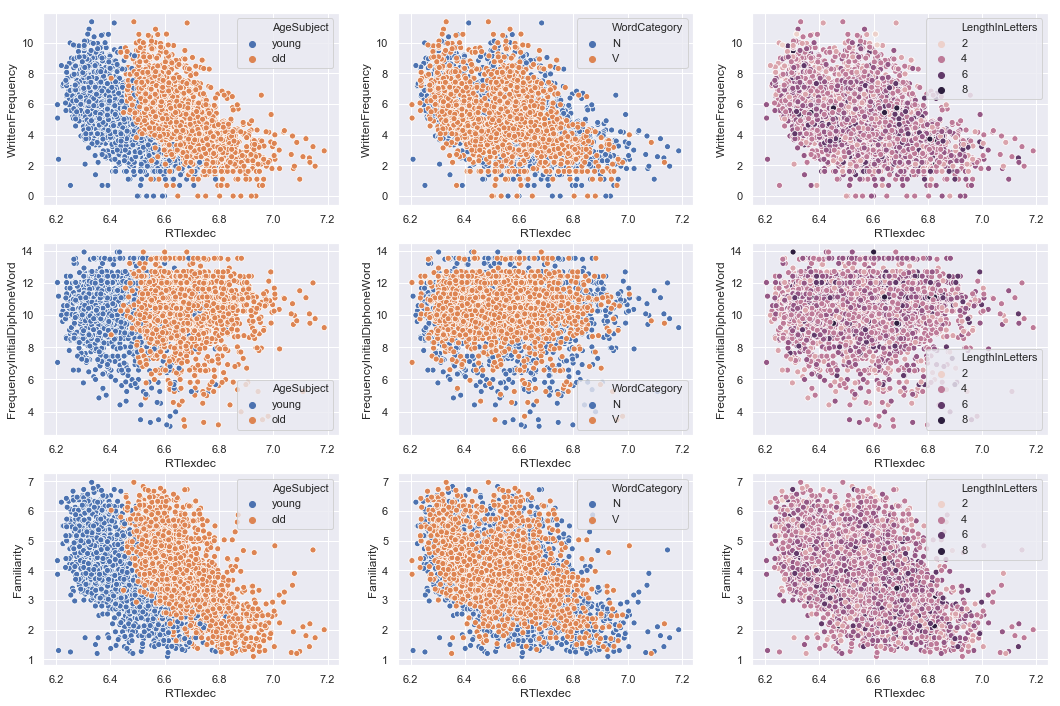

In [16]:
## Посмотрим зависимость целевой переменной от вещественных признаков в разрезе категориальных
 
cat_col = ['AgeSubject', 'WordCategory', 'LengthInLetters']  # categorical features
num_col = ['WrittenFrequency','FrequencyInitialDiphoneWord', 'Familiarity']  # numeric features

i = 1 # counter
for num_c in num_col:
    for cat_c in cat_col:
        plt.subplot(3,3,i)
        sns.scatterplot(x = 'RTlexdec', y = num_c, data = df, hue = cat_c)
        i += 1
        
fig = plt.gcf()
fig.set_size_inches(18,12)

In [17]:
df.LengthInLetters.unique()

array([3, 5, 6, 4, 2, 7], dtype=int64)

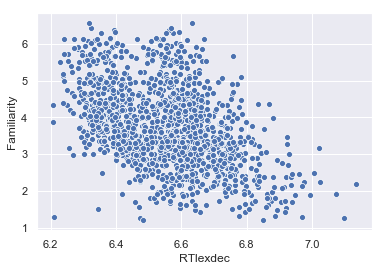

In [56]:
sns.scatterplot(x = 'RTlexdec', y = 'Familiarity', data = df[df.LengthInLetters == 5])

In [19]:
df[df.LengthInLetters == 2]

,RTlexdec,Familiarity,AgeSubject,WrittenFrequency,WordCategory,LengthInLetters,FrequencyInitialDiphoneWord
100,6.316749,6.47,young,10.554353,N,2,11.306037
1552,6.606839,6.47,old,10.554353,N,2,11.306037
2967,6.316749,6.47,young,10.554353,V,2,11.306037
3588,6.264350,6.37,young,9.845382,V,2,10.983664
3799,6.606839,6.47,old,10.554353,V,2,11.306037
4420,6.613344,6.37,old,9.845382,V,2,10.983664


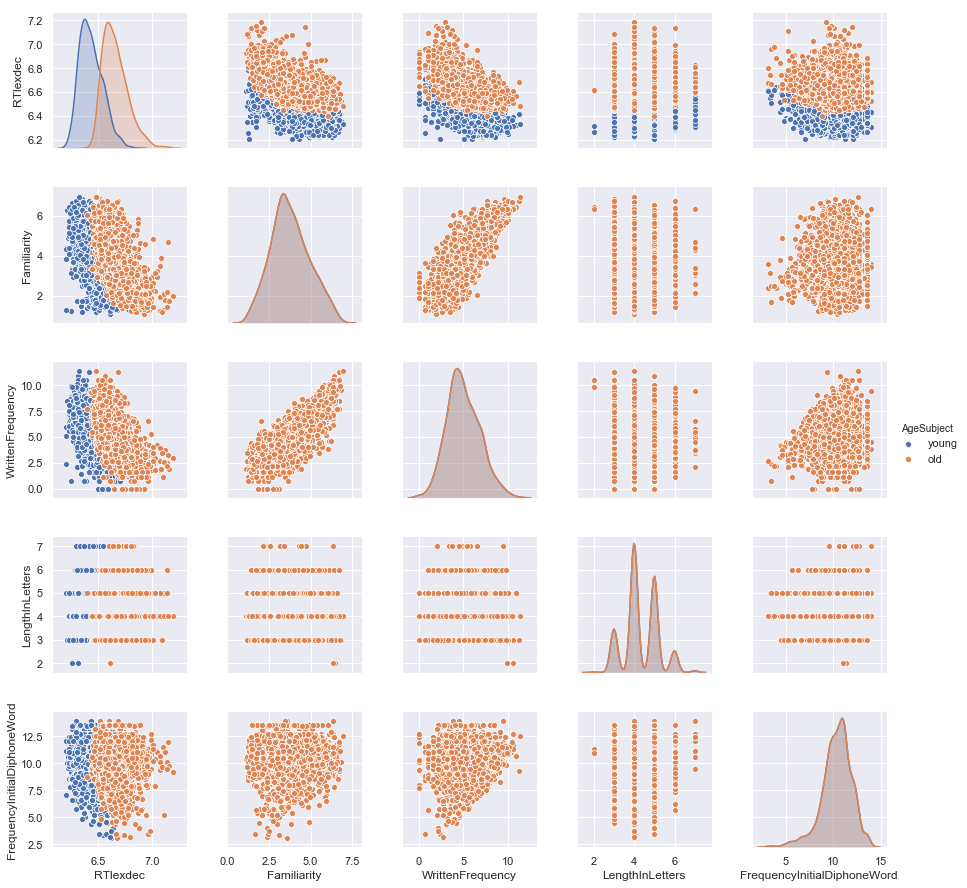

In [20]:
sns.pairplot(df, hue = 'AgeSubject')

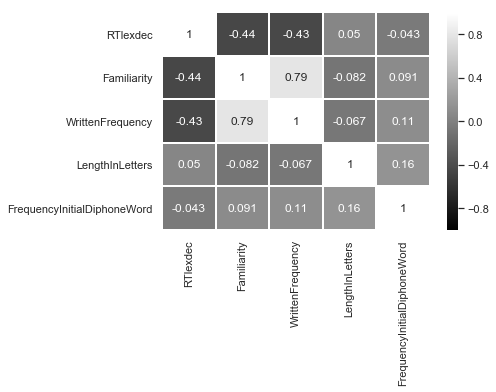

In [21]:
sns.heatmap(df.corr(), annot = True, lw = 1, vmin = -1, vmax = 1, cmap ='gist_gray')

2) Закодируйте категориальные признаки. Начните с OneHotEncoding, затем попробуйте счетчики.

In [22]:
df.head(1)

,RTlexdec,Familiarity,AgeSubject,WrittenFrequency,WordCategory,LengthInLetters,FrequencyInitialDiphoneWord
0,6.543754,2.37,young,3.912023,N,3,10.129308


In [23]:
X = df.copy()

# Перекодируем признаки
X['AgeSubject'] = X['AgeSubject'].apply(lambda x: 1 if x == 'young' else 0)
X['WordCategory'] = X['WordCategory'].apply(lambda x: 1 if x == 'N' else 0)
X['LengthInLetters'] = pd.Categorical(X['LengthInLetters'])

X = pd.get_dummies(X)


y = X['RTlexdec'].values

X.drop('RTlexdec', axis = 1, inplace = True)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state = 11081993)

3) Сделайте масштабирование данных.

In [24]:
sc = StandardScaler()
sc.fit(xtrain, ytrain)

xtrain, xtest = sc.transform(xtrain), sc.transform(xtest)

4) Обучите линейную регрессию, посмотрите на качество (r2_score) на кросс-валидации.

In [25]:
m = LinearRegression()
m.fit(xtrain, ytrain)
r2_score(ytest, m.predict(xtest)), mean_squared_error(ytest, m.predict(xtest))

(0.6968823335775126, 0.007479010094298787)

In [26]:
cross_val_score(LinearRegression(), X, y, scoring='r2', cv = 5).mean()

0.56483467767109

5) Выведите на экран веса признаков, дайте интерпретацию этим весам.

[-3.92476919e-02 -1.12161829e-01 -3.76969966e-02  8.86880490e-04
 -7.95842998e-05  3.27625315e-03 -2.17283116e-03  4.70482699e-04
 -2.17050829e-03  4.78172127e-03  2.60898031e-03]


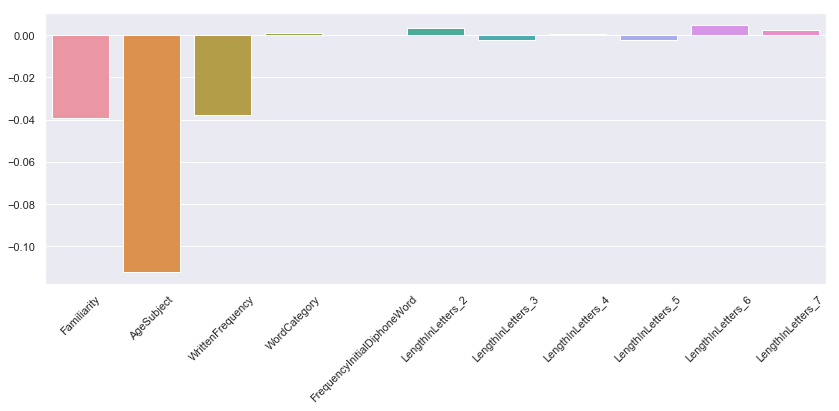

In [27]:
ax = sns.barplot(x = X.columns, y = m.coef_)
fig = plt.gcf()
fig.set_size_inches(14,5)
_ = ax.set_xticklabels(X.columns, rotation = 45)
print(m.coef_)

1. Как было выяснено на этапе предварительного анализа данных, AgeSubject наиболее информативный признак
2. Далее два коррелирующих между собой признака
3. Остальные не особо важны

6) Поработайте над созданием новых признаков (функции от исходных признаков, функции от пар признаков и т.д.). Добейтесь увеличения качества исходного алгоритма.

r2 score = 	 0.746276179803387


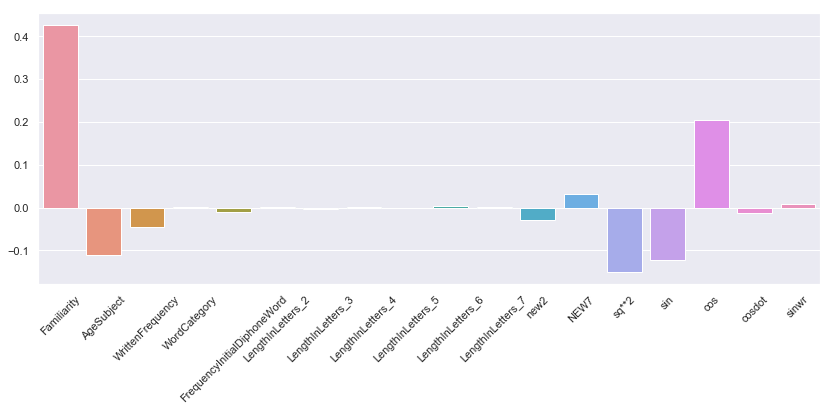

In [28]:
X = df.copy()

# Перекодируем признаки
X['AgeSubject'] = X['AgeSubject'].apply(lambda x: 1 if x == 'young' else 0)
X['WordCategory'] = X['WordCategory'].apply(lambda x: 1 if x == 'N' else 0)
X['LengthInLetters'] = pd.Categorical(X['LengthInLetters'])

X = pd.get_dummies(X)

y = X['RTlexdec'].values
X.drop(['RTlexdec'], axis = 1, inplace = True)


# Попробуем создать новые признаки

X['Familiarity'] = X['Familiarity'].apply(lambda x: np.log(x))
#X['new'] =  X['Familiarity']*X['AgeSubject']
X['new2'] =  X['Familiarity']*X['WrittenFrequency']
#X['new3'] =  X['Familiarity']*X['WrittenFrequency']*X['AgeSubject']
#X['NEW6'] = X['FrequencyInitialDiphoneWord']*X['Familiarity']
X['NEW7'] = X['FrequencyInitialDiphoneWord']*X['WrittenFrequency']
#X['NEW8'] = X['FrequencyInitialDiphoneWord']*X['AgeSubject']
X['sq**2'] =  X['Familiarity']* X['Familiarity']
X['sin'] = np.sin(X['Familiarity'])
X['cos'] = np.cos(X['Familiarity'])
X['cosdot'] = np.cos(X['WrittenFrequency'])
X['sinwr'] = np.sin(X['WrittenFrequency'])
#X['sinF'] = np.cos(X['FrequencyInitialDiphoneWord'])


xtrain, xtest, ytrain, ytest = train_test_split(X, y)#, random_state = 11081993)

sc = StandardScaler()
sc.fit(xtrain, ytrain)

xtrain, xtest = sc.transform(xtrain), sc.transform(xtest)

#xtrain, xtest, ytrain, ytest = train_test_split(X, y,  test_size = .15, random_state = 11081993)
m = LinearRegression()
m.fit(xtrain, ytrain)
print('r2 score = \t', r2_score(ytest, m.predict(xtest)))

ax = sns.barplot(x = X.columns, y = m.coef_)
fig = plt.gcf()
fig.set_size_inches(14,5)
_ = ax.set_xticklabels(X.columns, rotation = 45)
# print(m.coef_)

In [29]:
cross_val_score(LinearRegression(), X, y, scoring='r2', cv = 5).mean()

0.6134787439936579

## Выводы 


В целом, качество алгоритма улучшилось,
r2_score с **0.6147861598758426** до **0.7390594939251802**

На кросс-валидации с **0.56483467767109** до **0.6134787439936571**

Посмотрим, не переобучился ли алгоритм?

In [34]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y)
m = LinearRegression()
m.fit(xtrain, ytrain)
mean_squared_error(ytrain, m.predict(xtrain)), mean_squared_error(ytest, m.predict(xtest))
r2_score(ytrain, m.predict(xtrain)), r2_score(ytest, m.predict(xtest))

(0.7539057466910695, 0.7412260039380907)

В принципе, дальнейшее усложнение модели ведет к переобучению, в целом результаты приемлемые (пограничные). Возможно стоит убрать 1-2 признака из модели. Ситуация пограничная

# Попробуем другие модели

In [37]:
import warnings  # Отключим предупреждения 
warnings.filterwarnings('ignore')

# Попробуем регрессию Лассо, подберем альфа на кросс-валидации, смотрим на качество


m = LassoCV(cv = 5)
m.fit(xtrain, ytrain)
a = m.alpha_


m = Lasso(alpha=a)
m.fit(xtrain, ytrain)
print('r2 score = \t', r2_score(ytest, m.predict(xtest)))

r2 score = 	 0.728312280338614


In [38]:
## Lasso на кросс валидации
cross_val_score(Lasso(alpha=a), X, y, scoring='r2', cv = 5).mean()

0.5970999145685525

In [39]:
m = RidgeCV(alphas=np.logspace(10,0.0001))
m.fit(xtrain, ytrain)

b = m.alpha_

m = Ridge(alpha=b)
m.fit(xtrain, ytrain)
print('r2 score = \t', r2_score(ytest, m.predict(xtest)))

r2 score = 	 0.7394718524590954


In [40]:
cross_val_score(Ridge(alpha=b), X, y, scoring='r2', cv = 5).mean()

0.6107899925388752

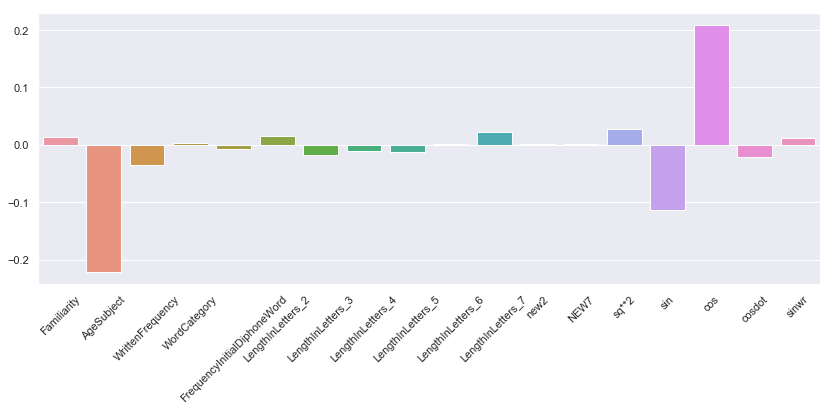

In [41]:
ax = sns.barplot(x = X.columns, y = m.coef_)
fig = plt.gcf()
fig.set_size_inches(14,5)
_ = ax.set_xticklabels(X.columns, rotation = 45)

## Качество алгоритмов сходное

## Попробуем счетчики и лучшие наработки из предыдущих моделей

In [46]:
X = df.copy()

In [47]:
X.groupby(by = 'WordCategory').agg('RTlexdec').mean()

WordCategory
N    6.554758
V    6.541964
Name: RTlexdec, dtype: float64

In [48]:
X.groupby(by = 'LengthInLetters').agg('RTlexdec').mean()

LengthInLetters
2    6.454145
3    6.537023
4    6.550375
5    6.549219
6    6.577259
7    6.591524
Name: RTlexdec, dtype: float64

In [49]:
## Функции счетчики
def f1(x):
    if x == 'young':
        return 6.439237
    else:
        return 6.660958
    
    
def f2(x):
    if x == 'N':
        return 6.554758
    else:
        return 6.541964
    
def f3(x):
    if x == 2:
        return 6.454145
    elif x == 3:
        return 6.537023
    elif x == 4:
        return 6.550375
    elif x == 5:
        return 6.549219
    elif x == 6:
        return 6.577259
    elif x == 7:
        return 6.591524

r2 score = 	 0.7275490444007866


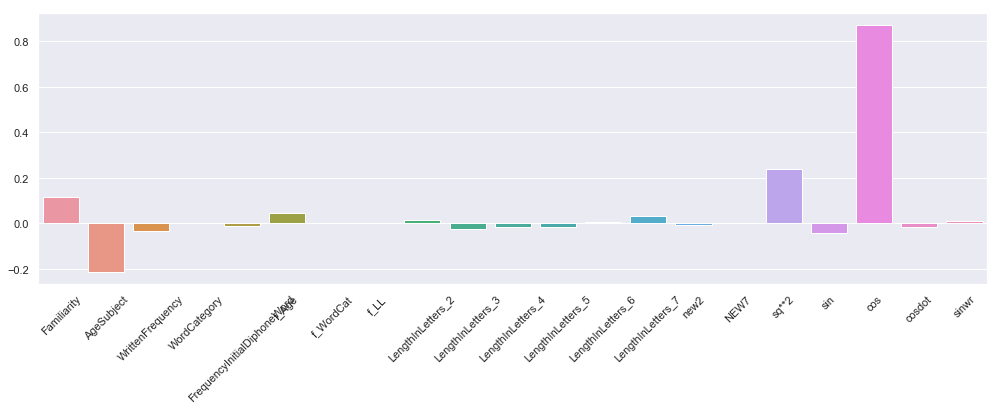

In [51]:
X = df.copy()

## Признаки-счетчики
X['f_Age'] = X['AgeSubject'].apply(lambda x: f1(x))
X['f_WordCat'] = X['WordCategory'].apply(lambda x: f2(x))
X['f_LL'] = X['LengthInLetters'].apply(lambda x: f3(x))

## Перекодируем категориальные признаки
X['AgeSubject'] = X['AgeSubject'].apply(lambda x: 1 if x == 'young' else 0)
X['WordCategory'] = X['WordCategory'].apply(lambda x: 1 if x == 'N' else 0)
X['LengthInLetters'] = pd.Categorical(X['LengthInLetters'])

X = pd.get_dummies(X)

# Попробуем создать новые признаки

X['Familiarity'] = X['Familiarity'].apply(lambda x: np.log(x))
X['new2'] =  X['Familiarity']*X['WrittenFrequency']
X['NEW7'] = X['FrequencyInitialDiphoneWord']*X['WrittenFrequency']
X['sq**2'] =  X['Familiarity']* X['Familiarity']
X['sin'] = np.sin(X['Familiarity'])
X['cos'] = np.cos(X['Familiarity'])
X['cosdot'] = np.cos(X['WrittenFrequency'])
X['sinwr'] = np.sin(X['WrittenFrequency'])



y = X['RTlexdec'].values
X.drop(['RTlexdec'], axis = 1, inplace = True)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state = 11081993)

m = LinearRegression()
m.fit(xtrain, ytrain)
print('r2 score = \t', r2_score(ytest, m.predict(xtest)))

ax = sns.barplot(x = X.columns, y = m.coef_)
fig = plt.gcf()
fig.set_size_inches(17,5)
_ = ax.set_xticklabels(X.columns, rotation = 45)

In [52]:
cross_val_score(LinearRegression(), X, y).mean()

0.6504572264363859

In [53]:
# Посмотрим качество на трейне
print('r2 score = \t', r2_score(ytrain, m.predict(xtrain)))

r2 score = 	 0.7575398667122413


Таким образом, добавив счетчики, мы получили модель с максимальным результатом 

с качеством (r2_score) на кросс-валидации, увеличившимся с  **0.6134787439936571** до **0.650457226436386**
